# How can neural network models be used to identify key parameters that lead to road collisions and to predict car accident rates more accurately?

### Abstract

------

## Introduction

## Literature review

**Deep Belief Networks** (DBN) ...


- Requirements: Packages used to run the analysis and global variables

In [1]:
#  Packages for data manipulation and processing
import numpy as np                      # list and matrix calculation
import pandas as pd                     # csv file processing

# Supervied leraning analysis tools
from torch.utils.data import Dataset            # training dataset class
from torch.utils.data import random_split       # randomly split a dataset into multiple subsets
from sklearn.preprocessing import LabelEncoder  # encode target value to label

# Visualization tools
import matplotlib.pyplot as plt
import seaborn as sns                   # built-in themes to draw attractive and informative statistical graphics.

In [2]:
# raw data relative path
rawDataPath = "./data/dft-road-casualty-statistics-casualty-last-5-years.csv"
# dtype: str location indicator of raw data
dtype_specification = {0: str, 2: str, 18: str}

### Data gathering
[Ref](https://machinelearningmastery.com/pytorch-tutorial-develop-deep-learning-models/)

In [39]:

# Dataset class def
class TrainDataset(Dataset):

    def __init__(self, path:str, loc_remove:list[str], loc_test=None, dtype:dict=None):
        """
        Training dataset initialization method used to convert the data frame from csv file
        into list array style that can be used for batch seperation.
        
        Parameters
        ------
        path : str
            The relative file path of dataset
        loc_remove : list[str]
            The columns will be removed
        loc_test : int, optinal
            The index of testing columns
        dtype : dict, optional
            The specific data type of column(s)
        """
        # load the csv file as a dataframe
        df = pd.read_csv(path, dtype=dtype)
        print(f"Column overview: {df.columns}\nDf size: {np.shape(df)}")
        # remove useless columns
        df = df.drop(columns=loc_remove)
        # print first row to preview df
        df.head(1)
        # stroe the df
        self.raw = df
        # store the inputs and outputs
        if loc_test is None:
            self.X = df.values[:, :-1]
            self.y = df.values[:, -1]
        else:
            self.X = df.drop(df.columns[loc_test], axis=1)
            self.y = df.iloc[:, loc_test]
        # label encode target
        self.y = LabelEncoder().fit_transform(self.y)
        # ensure output data is floats
        self.y = self.y.astype('float32')
        # reshapes output array to have len(self.y) rows and 1 column
        self.y = self.y.reshape((len(self.y), 1))

    def __len__(self):
        """
        Check the size of dataset.

        Return
        ------
        len(self.X) : int
            The size of X
        """
        print(f"Training dataset length: {len(self.X)}, test dataset length: {len(self.y)}")
        return len(self.X)
 
    # get a row at an index
    def __getitem__(self, idx):
        return [self.X[idx], self.y[idx]]

    def describe(self, cols: list[str]=None):
        """
        generates descriptive statistics that summarize the df.

        Parameter
        ------
        cols: list[str]
            specific clumns that will be described
        """
        if cols is not None:
            print(self.raw[cols].describe(include='all'))
        else:
            print(self.raw.describe(include='all'))

    def clean_na(self):
        """
        data processing step. 
        Remove rows with any null values and replace '-1' with NaN,
        then remove any rows with NaN values.
        """
        self.raw = self.raw.dropna()
        self.raw = self.raw.replace('-1', pd.NA).dropna()

    def get_splits(self, n_test=0.33):
        """
        split the dataset and get indexes for train and test rows.

        Parameter
        ------
        n_test : float
            The split ratio of testing dataset [0, 1]
        """
        # determine sizes
        test_size = round(n_test * len(self.X))
        train_size = len(self.X) - test_size
        # calculate the split
        return random_split(self, [train_size, test_size])

### Data pre-processing

Checking the note in the data readme file, -1 means there is a data fail to be recored or out of the range.

In [40]:
dataset = TrainDataset(rawDataPath, ["accident_index", "accident_year", "accident_reference"],
             dtype=dtype_specification)

Column overview: Index(['accident_index', 'accident_year', 'accident_reference',
       'vehicle_reference', 'casualty_reference', 'casualty_class',
       'sex_of_casualty', 'age_of_casualty', 'age_band_of_casualty',
       'casualty_severity', 'pedestrian_location', 'pedestrian_movement',
       'car_passenger', 'bus_or_coach_passenger',
       'pedestrian_road_maintenance_worker', 'casualty_type',
       'casualty_home_area_type', 'casualty_imd_decile', 'lsoa_of_casualty'],
      dtype='object')
Df size: (693028, 19)


In [41]:
dataset.clean_na()
# Provide a summary of the dataset
descirbe_columns = ['vehicle_reference', 'casualty_reference', 'casualty_class', 'sex_of_casualty', 'age_of_casualty', 'age_band_of_casualty',
                    'casualty_severity', 'pedestrian_location', 'pedestrian_movement', 'car_passenger', 'bus_or_coach_passenger',
                    'pedestrian_road_maintenance_worker', 'casualty_type', 'casualty_home_area_type', 'casualty_imd_decile']
dataset.describe(descirbe_columns)

       vehicle_reference  casualty_reference  casualty_class  sex_of_casualty  \
count      466070.000000       466070.000000   466070.000000    466070.000000   
mean            1.464308            1.341756        1.446781         1.375499   
std             2.066524            2.956075        0.713259         0.514312   
min             1.000000            1.000000        1.000000        -1.000000   
25%             1.000000            1.000000        1.000000         1.000000   
50%             1.000000            1.000000        1.000000         1.000000   
75%             2.000000            1.000000        2.000000         2.000000   
max           999.000000          999.000000        3.000000         9.000000   

       age_of_casualty  age_band_of_casualty  casualty_severity  \
count    466070.000000         466070.000000      466070.000000   
mean         37.103371              6.372813           2.808675   
std          19.189729              2.363139           0.419463   
mi

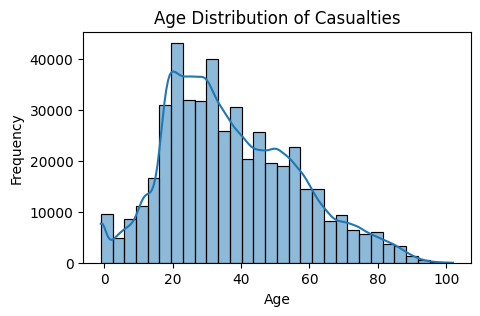

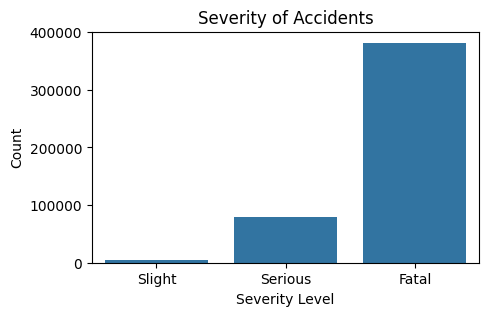

Text(0, 0.5, 'Casualty Type')

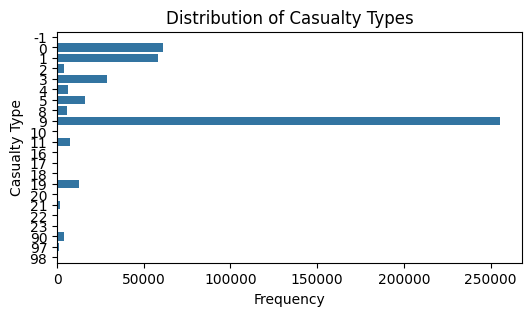

In [46]:
# Ensure proper rendering of plots
%matplotlib inline
# # 1. Trend of Accidents Over Years
# plt.figure(figsize=(10, 6))
# sns.countplot(x='accident_year', data=df)
# plt.title('Trend of Accidents Over Years')
# plt.ylabel('Number of Accidents')
# plt.xlabel('Year')
# plt.xticks(rotation=45)
# plt.show()

# 2. Age Distribution of Casualties
plt.figure(figsize=(5, 3))
sns.histplot(dataset.raw['age_of_casualty'], bins=30, kde=True)
plt.title('Age Distribution of Casualties')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

# 3. Severity of Accidents
plt.figure(figsize=(5, 3))
sns.countplot(x='casualty_severity', data=dataset.raw)
plt.title('Severity of Accidents')
plt.xlabel('Severity Level')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1, 2], labels=['Slight', 'Serious', 'Fatal'])
plt.show()

# 4. Casualty Type Distribution
plt.figure(figsize=(6, 3))
# Count the frequency of each casualty type
casualty_type_counts = dataset.raw['casualty_type'].value_counts().sort_values(ascending=False)
# Plot as a bar chart
sns.barplot(x=casualty_type_counts.values, y=casualty_type_counts.index, orient='h')
plt.title('Distribution of Casualty Types')
plt.xlabel('Frequency')
plt.ylabel('Casualty Type')